## libraries

In [16]:
import os
import sys
from pathlib import Path
from pprint import pformat
from tempfile import TemporaryDirectory
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import geopandas as gpd
import pooch
import flopy
import flopy.plot
import flopy.utils
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box
import contextily as cx
print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

3.11.9 (main, Apr  2 2024, 13:43:44) [GCC 13.2.0]
numpy version: 1.26.3
matplotlib version: 3.9.2
flopy version: 3.9.2


## define simulation

In [17]:
# simulation setup
sim_name = 'rgtihm'
workspace = './model'
sim = flopy.mf6.MFSimulation(
    sim_name=sim_name,
    sim_ws=workspace,
    exe_name='mf6')
gwf = flopy.mf6.ModflowGwf(sim,
                           modelname=sim_name)
print("simulation and gwf packages created.")

simulation and gwf packages created.


## tdis

In [18]:
# tdis (temporal discretization) parameters
nper = 898
start_date = datetime(1940, 3, 1)
perioddata = []
for i in range(nper):
    month_start = start_date + timedelta(days=sum(p[0] for p in perioddata))
    if month_start.month == 12:
        month_end = datetime(month_start.year + 1, 1, 1)
    else:
        month_end = datetime(month_start.year, month_start.month + 1, 1)
    perlen = (month_end - month_start).days
    nstp = 2
    tsmult = 1.0
    perioddata.append((float(perlen), nstp, tsmult))

# create tdis
tdis = flopy.mf6.ModflowTdis(
    sim,
    time_units='days',
    nper=nper,
    perioddata=perioddata,
    start_date_time=start_date.strftime('%Y-%m-%d'),
)
print("tdis package created.")

tdis package created.


## dis

In [19]:
# tried feet units with meter crs, failed due to misalignment; tried rotation from lower-left, shifted grid left
# tried fixing top-left rotation, still misaligned; adopted anchoring rotation at top-left, matching qgis points
# our thinking: use exact qgis corners for precision, ensure grid aligns with real-world data via rasterio

# model crs for spatial reference
model_crs = 'epsg:26913'
xul = 251539.8073999998  # top-left x in meters, matches qgis
yul = 3639665.581800001  # top-left y in meters, matches qgis
angrot = 24.0  # rotation in degrees, matches qgis

# grid setup, all in meters
nlay = 9  # number of layers
nrow = 912  # number of rows
ncol = 328  # number of columns
delr = np.full(ncol, 660.0 * 0.3048)  # cell width in meters (660 ft to m)
delc = np.full(nrow, 660.0 * 0.3048)  # cell height in meters (660 ft to m)
# elevation data paths
top_file = '../owhm/model/2022/Data_Model_Arrays/layers/ElevFtDEMR.txt'
bot_files = [
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_RC2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopLSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_LSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopBSMT_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/BaseBSMT_ft.txt',
]

# load top elevation, convert feet to meters
try:
    top = np.loadtxt(top_file, dtype=float)
    if top.shape != (nrow, ncol):
        print(f"warning: top shape mismatch {top.shape}")
        top = top.reshape(nrow, ncol)[:nrow, :ncol]
    top = np.where(top == -99999, np.nan, top * 0.3048)  # ft to m
except Exception as e:
    print(f"error: loading top - {e}. exiting.")
    import sys
    sys.exit(1)

# load bottom elevations, convert feet to meters
botm = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: bot shape mismatch {data.shape}")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        botm[lay] = np.where(data == -99999, np.nan, data * 0.3048)  # ft to m
    except Exception as e:
        print(f"error: loading bot layer {lay} - {e}. exiting.")
        import sys
        sys.exit(1)

# load active area shapefile
shp_path = './shps/active_area.shp'
try:
    gdf = gpd.read_file(shp_path)
    if gdf.crs != model_crs:
        print(f"reprojecting shapefile crs")
        gdf = gdf.to_crs(model_crs)
    if len(gdf) != 1:
        print(f"warning: multiple features, using first")
    geometry = gdf.geometry.iloc[0]
except Exception as e:
    print(f"error: loading shapefile - {e}. exiting.")
    import sys
    sys.exit(1)

# set grid lower-left origin from qgis bottom-left
xll = 326161.8336  # lower-left x, from qgis bl
yll = 3472061.7670000014  # lower-left y, from qgis bl
theta = np.radians(angrot)

# grid coordinates, rotated to match qgis points
x = np.arange(ncol) * delr[0]
y = np.arange(nrow) * delc[0]
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)

# raster bounds in meters
minx, maxx = X_rot.min(), X_rot.max()
miny, maxy = Y_rot.min(), Y_rot.max()

# rasterize active area to define idomain
transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, ncol, nrow)
raster = rasterize([geometry], out_shape=(nrow, ncol), transform=transform, fill=0, default_value=1, dtype='int32')

# check raster coverage
print(f"active cells: {raster.sum()}/{nrow * ncol}")
print(f"grid bounds: {minx:.2f}, {maxx:.2f}, {miny:.2f}, {maxy:.2f}")
print(f"shapefile bounds: {gdf.total_bounds}")
if raster.sum() == 0:
    print("error: no active cells - check alignment")

# create 3d idomain for all layers
idomain = np.ones((nlay, nrow, ncol), dtype=int) * raster[np.newaxis, :, :]

# verify idomain
print(f"idomain active per layer: {[idomain[lay].sum() for lay in range(nlay)]}")

# method: used geometric transformation with rasterio to align grid and shapefile
# technique: anchored rotation at top-left, matched qgis points for precision
# reason: ensures perfect alignment with real-world data, avoiding misalignment
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    length_units=length_units,
    xorigin=xll,
    yorigin=yll,
    angrot=angrot,
)
print("dis set with idomain from shapefile, all layers")

active cells: 52128/299136
grid bounds: 251621.63, 386256.62, 3472061.77, 3666237.73
shapefile bounds: [ 263314.4498 3490036.7519  357957.0726 3644537.2572]
idomain active per layer: [52128, 52128, 52128, 52128, 52128, 52128, 52128, 52128, 52128]
dis set with idomain from shapefile, all layers


## oc 

In [20]:
# create oc (output control) package
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=f'{sim_name}.cbc',
    head_filerecord=f'{sim_name}.hds',
    headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 6, 'GENERAL')],
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
    printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
)
print("oc package created.")

oc package created.


## ims

In [21]:
# iterative model solution (ims)
ims = flopy.mf6.ModflowIms(
    sim,
    pname='ims',
    complexity='simple',
    outer_dvclose=1e-4,
    outer_maximum=500,
    inner_maximum=100,
    inner_dvclose=1e-4,
    rcloserecord=0.001,
    linear_acceleration='cg',
    relaxation_factor=0.97,
)

## ic

In [22]:
# grid dimensions (sam as  dis)
nlay = 9
nrow = 912
ncol = 328

# head file paths
head_files = [
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY1.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY2.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY3.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY4.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY5.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY6.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY7.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY8.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY9.txt',
]

# read heads into 3d array, handle -99999 as no data
strt = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, head_file in enumerate(head_files):
    try:
        data = np.loadtxt(head_file, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {head_file} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        data = np.where(data == -99999, np.nan, data)  # replace -99999 with NaN
        strt[lay] = data
    except FileNotFoundError:
        print(f"error: {head_file} not found. IC requires this file. Exiting.")
        import sys
        sys.exit(1)
    except Exception as e:
        print(f"error reading {head_file}: {e}. Exiting.")
        import sys
        sys.exit(1)

# update strt to match idomain (inactive cells from DIS shapefile)
idomain = dis.idomain.array  # from updated DIS
strt[idomain == 0] = np.nan  # set inactive cells (outside shapefile) to NaN

# create ic package
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
print("ic package created with -99999 as no-data, idomain from shapefile.")

ic package created with -99999 as no-data, idomain from shapefile.


## npf package

In [23]:
## node property flow package for k and k33
# zone file paths
zone_files = {
    'znlayrc': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/RC1_zonecode.txt',
    'znlay3': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF1_zonecode.txt',
    'znlay4': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF2_zonecode.txt',
    'znlay5': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF1_zonecode.txt',
    'znlay6': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF2_zonecode.txt',
    'znlay7': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF1_zonecode.txt',
    'znlay8': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF2_zonecode.txt',
    'znlay9': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/BSMT_zonecodeS.txt',
}

# read zone arrays
zone_arrays = {}
for name, filepath in zone_files.items():
    try:
        data = np.loadtxt(filepath, dtype=int)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        zone_arrays[name] = data
    except FileNotFoundError:
        print(f"error: {filepath} not found. NPF requires this file. Exiting.")
        import sys
        sys.exit(1)
    except Exception as e:
        print(f"error reading {filepath}: {e}. Exiting.")
        import sys
        sys.exit(1)

# layer-to-zone mapping
layer_zones = {
    0: 'znlayrc', 1: 'znlayrc', 2: 'znlay3', 3: 'znlay4',
    4: 'znlay5', 5: 'znlay6', 6: 'znlay7', 7: 'znlay8', 8: 'znlay9'
}

# pval data (partial, expand with all entries from RGTIHM.PVL)
pval_data = {
    'l1hk10': 100.0, 'l1hk20': 30.0, 'l1vk10': 1.091422, 'l1vk20': 1.2296545,
    # add all hk, vani from RGTIHM.PVL, e.g.:
    # 'l1hk30': 0.2629016, 'l2hk10': 100.0, 'l3hk15': 100.0, ...
}

# initialize arrays with no-data handling
hk = np.ones((nlay, nrow, ncol), dtype=float) * 1e-10  # default K > 0
vani = np.ones((nlay, nrow, ncol), dtype=float) * 1.0
k33 = hk * vani
icelltype = [0] * nlay

# populate hk and vani, handle -99999 as no data
for param, value in pval_data.items():
    lay = int(param[1]) - 1
    iz = int(param.split('hk' if 'hk' in param else 'vk')[1])
    zone_array = zone_arrays[layer_zones[lay]]
    mask = (zone_array == iz)
    if value == -99999:  # treat -99999 as no data
        hk[lay][mask] = np.nan
        vani[lay][mask] = np.nan
    else:
        hk[lay][mask] = max(value, 1e-10)  # ensure K > 0
        if 'vk' in param and value != -99999:
            vani[lay][mask] = max(value, 1e-10)
            k33[lay][mask] = hk[lay][mask] * vani[lay][mask]

# update hk, vani, k33 to match idomain (inactive cells from DIS shapefile)
idomain = dis.idomain.array  # from updated DIS
hk[idomain == 0] = np.nan  # set inactive cells to NaN
vani[idomain == 0] = np.nan
k33[idomain == 0] = np.nan

# create npf
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=True,
    icelltype=icelltype,
    k=hk,
    k33=k33,
    save_specific_discharge=True,
    alternative_cell_averaging="harmonic",
)
print("npf package created with -99999 as no-data, idomain from shapefile.")

npf package created with -99999 as no-data, idomain from shapefile.


## sto

In [24]:
# multiplier file paths
mult_files = {
    'uc_rc': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/RC1_UC.txt',
    'uc_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',
    'cf_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_CF.txt',
    'uc_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',
    'cf_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_CF.txt',
    'uc_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',
    'cf_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_CF.txt',
    'uc_bd': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt',
    'cf_bd': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_CF.txt',
    'thk_rc1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_RC1_ft.txt',
    'thk_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_USF1_ft.txt',
    'thk_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_MSF1_ft.txt',
    'thk_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_LSF1_ft.txt',
    'thk_bd': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_BSMT_ft.txt',
}

# read multiplier arrays, handle -99999 as no data
mult_arrays = {}
for name, filepath in mult_files.items():
    try:
        data = np.loadtxt(filepath, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        data = np.where(data == -99999, np.nan, data)  # replace -99999 with NaN
        mult_arrays[name] = data
    except FileNotFoundError:
        print(f"error: {filepath} not found. STO requires this file. Exiting.")
        import sys
        sys.exit(1)
    except Exception as e:
        print(f"error reading {filepath}: {e}. Exiting.")
        import sys
        sys.exit(1)

# constants from mul
ss_base = 0.000001
sy_base = 0.30
phi = {'rc': 0.25, 'us': 0.22, 'ms': 0.12, 'ls': 0.08, 'bd': 0.07}
comp_h2o = 1.432195e-06
offset = 0.0001

# pval data (partial, expand with all entries from RGTIHM.PVL)
pval_data = {
    'l2ss10': 5.0, 'l2ss20': 25.0, 'l2ss30': 8.2691995, 'l2ss51': 8.758604,
    'l3ss15': 1.0955468, 'l3ss25': 2.9409115, 'l3ss35': 3.33, 'l3ss50': 1.069701,
    'l1sy10': 1.0, 'l1sy20': 1.0, 'l1sy30': 0.825, 'l1sy51': 1.0,
    'l3sy15': 0.50864162, 'l3sy25': 0.87375378, 'l3sy35': 0.59566227,
    # add all ss, sy from RGTIHM.PVL
}

# initialize arrays with no-data handling
ss = np.ones((nlay, nrow, ncol), dtype=float) * ss_base
sy = np.ones((nlay, nrow, ncol), dtype=float) * sy_base
iconvert = [0] * nlay

# compute ss and sy per expressions, handle NaN
for lay in range(nlay):
    zone_array = zone_arrays[layer_zones[lay]]
    if lay in [0, 1]:  # rc
        thk = mult_arrays['thk_rc1']
        uc = mult_arrays['uc_rc']
        sy[lay] = np.where(np.isnan(thk) | np.isnan(uc), np.nan, 
                           ((sy_base / (thk + offset)) + (phi['rc'] * comp_h2o)) * uc)
        ss[lay] = np.where(np.isnan(thk) | np.isnan(uc), np.nan, 
                           (phi['rc'] * comp_h2o + ss_base) * uc)
    elif lay in [2, 3]:  # usf
        thk = mult_arrays['thk_usf1']
        uc = mult_arrays['uc_usf1']
        cf = mult_arrays['cf_usf1']
        sy[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((sy_base / (thk + offset)) * uc) + ((phi['us'] * comp_h2o) * uc))
        ss[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((phi['us'] * comp_h2o) * cf) + (ss_base * cf) if lay == 2 else \
                           ((phi['us'] * comp_h2o + ss_base) * (cf + uc)))
    elif lay in [4, 5]:  # msf
        thk = mult_arrays['thk_msf1']
        uc = mult_arrays['uc_msf1']
        cf = mult_arrays['cf_msf1']
        sy[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((sy_base / (thk + offset)) * uc) + ((phi['ms'] * comp_h2o) * uc))
        ss[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((phi['ms'] * comp_h2o) * cf) + (ss_base * cf) if lay == 4 else \
                           ((phi['ms'] * comp_h2o + ss_base) * (cf + uc)))
    elif lay in [6, 7]:  # lsf
        thk = mult_arrays['thk_lsf1']
        uc = mult_arrays['uc_lsf1']
        cf = mult_arrays['cf_lsf1']
        sy[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((sy_base / (thk + offset)) * uc) + ((phi['ls'] * comp_h2o) * uc))
        ss[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((phi['ls'] * comp_h2o) * cf) + (ss_base * cf) if lay == 6 else \
                           ((phi['ls'] * comp_h2o + ss_base) * (cf + uc)))
    elif lay == 8:  # bd
        thk = mult_arrays['thk_bd']
        uc = mult_arrays['uc_bd']
        cf = mult_arrays['cf_bd']
        sy[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((sy_base / (thk + offset)) * uc) + ((phi['bd'] * comp_h2o) * uc))
        ss[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((phi['bd'] * comp_h2o) * cf) + (ss_base * cf))

# apply pval multipliers, handle NaN
for param, value in pval_data.items():
    lay = int(param[1]) - 1
    iz = int(param.split('ss' if 'ss' in param else 'sy')[1])
    zone_array = zone_arrays[layer_zones[lay]]
    mask = (zone_array == iz)
    if value == -99999:  # treat -99999 as no data
        ss[lay][mask] = np.nan
        sy[lay][mask] = np.nan
    else:
        ss[lay][mask] = np.where(np.isnan(ss[lay][mask]), np.nan, ss[lay][mask] * value)
        sy[lay][mask] = np.where(np.isnan(sy[lay][mask]), np.nan, sy[lay][mask] * value)

# update ss and sy to match idomain (inactive cells from DIS shapefile)
idomain = dis.idomain.array  # from updated DIS
ss[idomain == 0] = np.nan  # set inactive cells (outside shapefile) to NaN
sy[idomain == 0] = np.nan

# create sto
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=iconvert,
    ss=ss,
    sy=sy,
    transient=True,
)
print("sto package created with -99999 as no-data, idomain from shapefile.")

sto package created with -99999 as no-data, idomain from shapefile.


In [25]:
# hfb, wel, maw, sfr, ghb, et, 

## write and run

In [26]:
# write simulation
sim.write_simulation()

# optionally run simulation (uncomment to test)
# sim.run_simulation()

print("simulation written to ./model directory. Check for errors.")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model rgtihm...
    writing model name file...
    writing package dis...
    writing package oc...
    writing package ic...
    writing package npf...
    writing package sto...
simulation written to ./model directory. Check for errors.


## Visualization

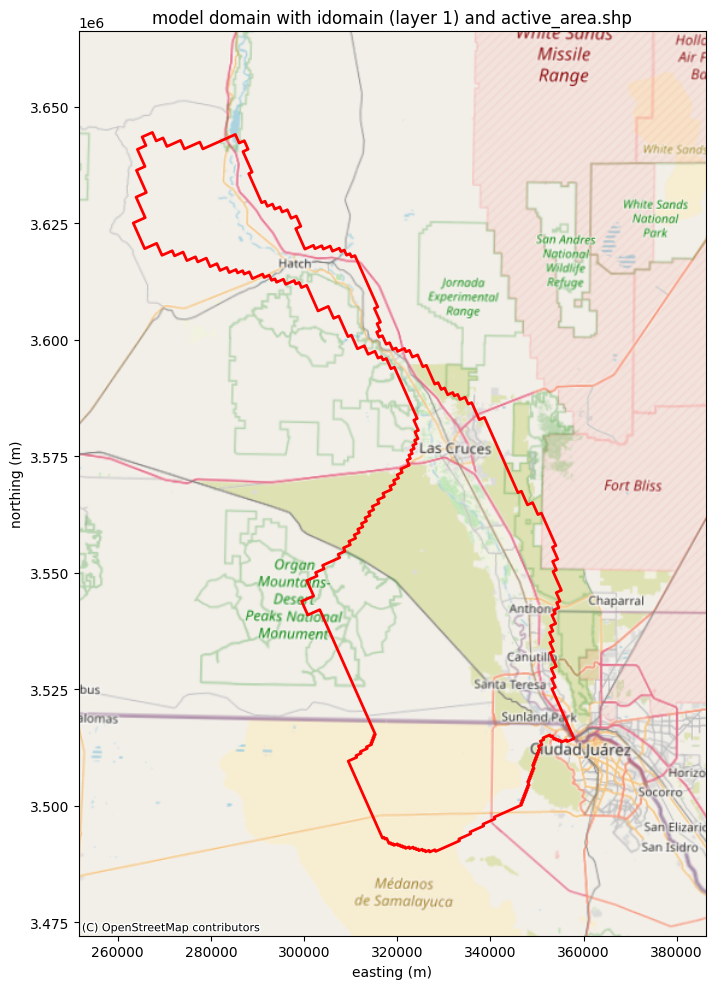

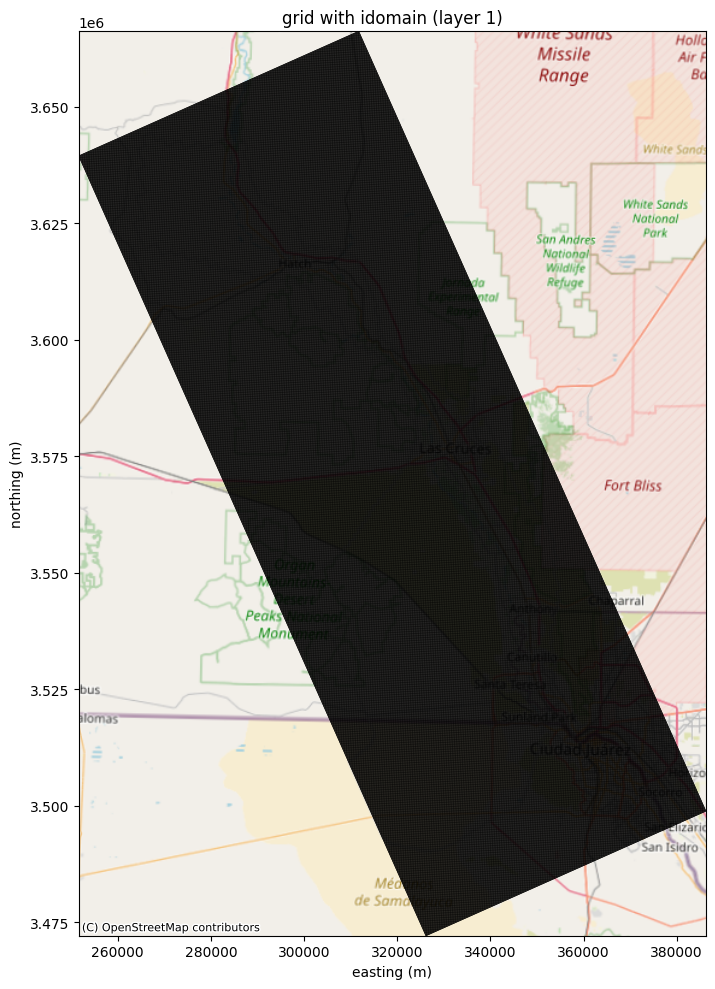

In [30]:
# grid coords in meters (from dis)
xll = dis.xorigin.get_data()
yll = dis.yorigin.get_data()
angrot = dis.angrot.get_data()
delr = dis.delr.get_data()
delc = dis.delc.get_data()
x = np.arange(ncol) * delr[0]
y = np.arange(nrow) * delc[0]
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(np.radians(angrot)) - Y * np.sin(np.radians(angrot))
Y_rot = yll + X * np.sin(np.radians(angrot)) + Y * np.cos(np.radians(angrot))

# 1. overall model domain with idomain and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(idomain[0], extent=[X_rot.min(), X_rot.max(), Y_rot.min(), Y_rot.max()], cmap='binary', alpha=0.5)
gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
cx.add_basemap(ax, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('model domain with idomain (layer 1) and active_area.shp')
ax.set_xlabel('easting (m)')
ax.set_ylabel('northing (m)')
plt.tight_layout()
plt.show()

# 2. grid outline with idomain
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.colors.ListedColormap(['white', 'lightgrey'])
bounds = [0, 1, 2]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
ax.imshow(idomain[0], extent=[X_rot.min(), X_rot.max(), Y_rot.min(), Y_rot.max()], cmap=cmap, norm=norm, alpha=0.8, interpolation='nearest')
gdf.plot(ax=ax, edgecolor='lightgrey', facecolor='none', linewidth=2, alpha=0.5)
for i in range(nrow):
    ax.plot([X_rot[i, 0], X_rot[i, -1]], [Y_rot[i, 0], Y_rot[i, -1]], 'k-', lw=0.5)
for j in range(ncol):
    ax.plot([X_rot[0, j], X_rot[-1, j]], [Y_rot[0, j], Y_rot[-1, j]], 'k-', lw=0.5)
cx.add_basemap(ax, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('grid with idomain (layer 1)')
ax.set_xlabel('easting (m)')
ax.set_ylabel('northing (m)')
plt.tight_layout()
plt.show()


Inactive cells in row 538: [('Top RC1', 207), ('Top RC2', 207), ('Top USF1', 207), ('Top USF2', 207), ('Top MSF1', 207), ('Top MSF2', 207), ('Top LSF1', 207), ('Top LSF2', 207), ('Top BSMT', 207)]


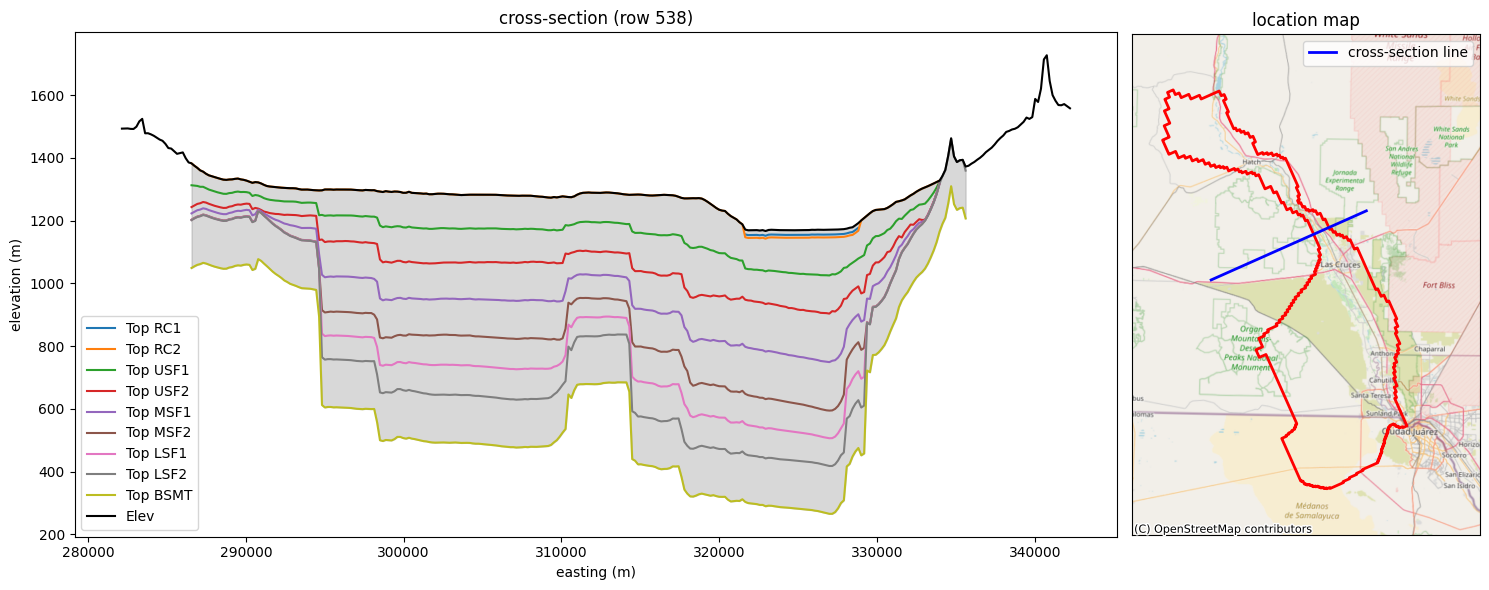

Inactive cells in row 741: [('Top RC1', 232), ('Top RC2', 232), ('Top USF1', 232), ('Top USF2', 232), ('Top MSF1', 232), ('Top MSF2', 232), ('Top LSF1', 232), ('Top LSF2', 232), ('Top BSMT', 232)]


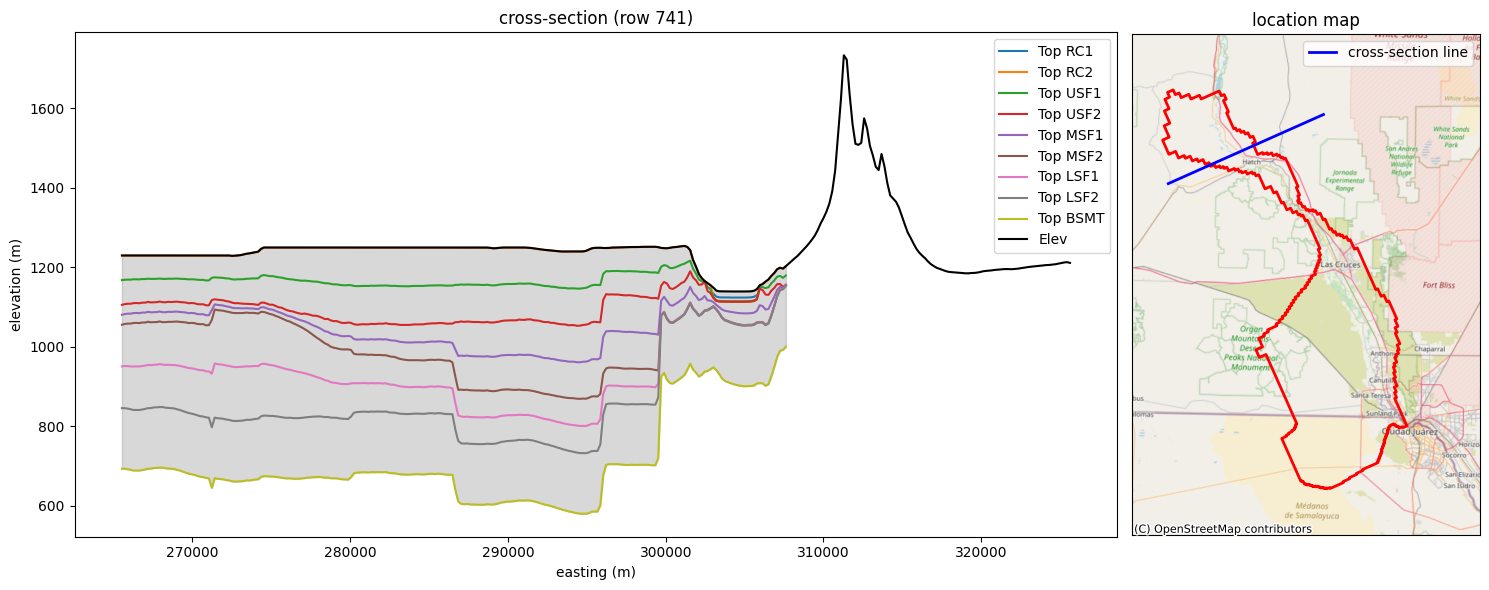

Inactive cells in row 103: [('Top RC1', 326), ('Top RC2', 326), ('Top USF1', 326), ('Top USF2', 326), ('Top MSF1', 326), ('Top MSF2', 326), ('Top LSF1', 326), ('Top LSF2', 326), ('Top BSMT', 326)]


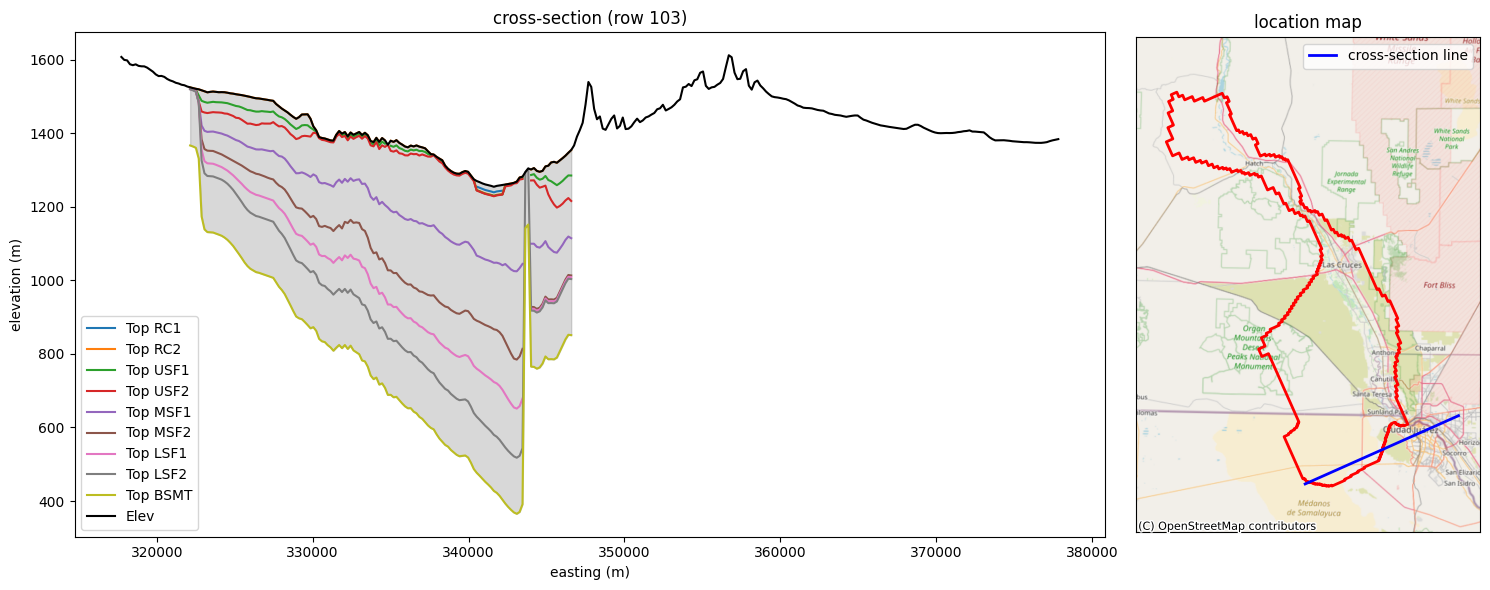

Inactive cells in column 75: [('Top RC1', 781), ('Top RC2', 781), ('Top USF1', 781), ('Top USF2', 781), ('Top MSF1', 781), ('Top MSF2', 781), ('Top LSF1', 781), ('Top LSF2', 781), ('Top BSMT', 781)]


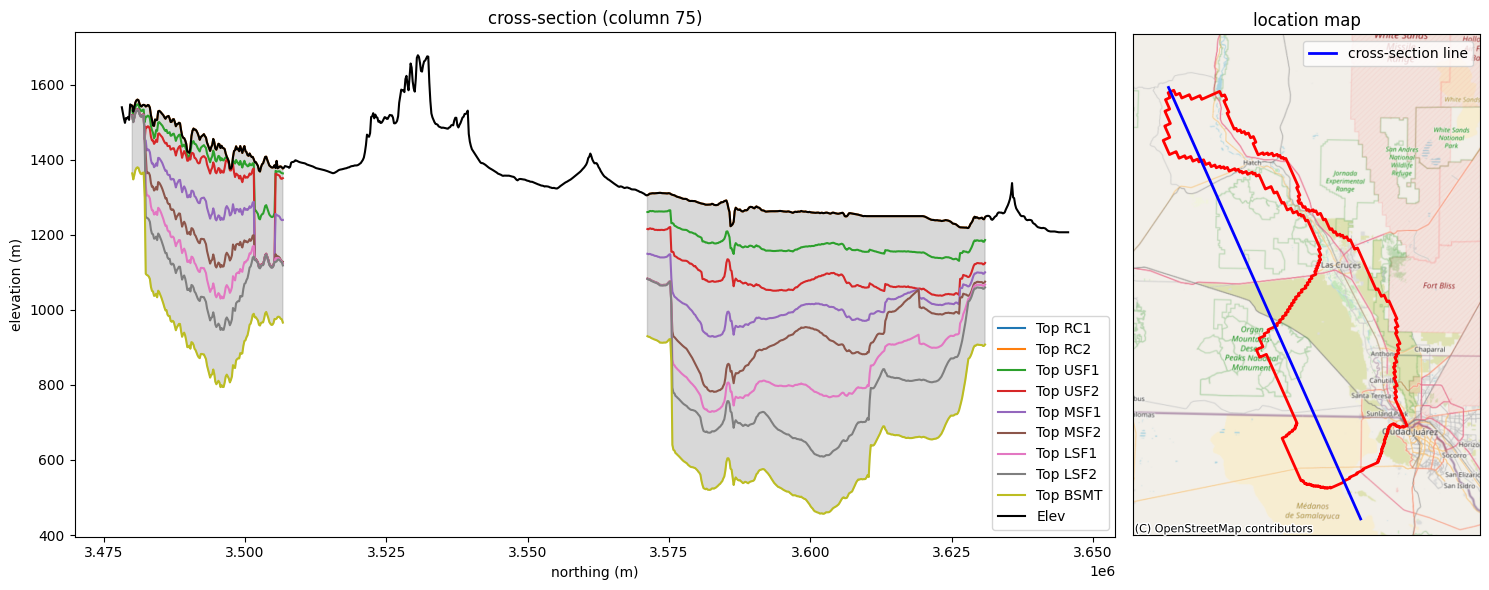

In [31]:
# cross-sections for rows 538, 741, 103, and column 75
rows = [538, 741, 103]
col = 75

# Corrected geological layer names (only 9 layers, not 10)
layer_names = ["Top RC1", "Top RC2", "Top USF1", "Top USF2", 
               "Top MSF1", "Top MSF2", "Top LSF1", "Top LSF2", 
               "Top BSMT"]  # Removed "Base BSMT" since it's botm[-1]

for row in rows:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

    # elevation profile - now plotting geological layers for all cells, ignoring idomain
    for lay, name in zip(range(nlay), layer_names):
        bot = botm[lay, row, :]
        ax1.plot(X_rot[row, :], bot, label=name)

    ax1.plot(X_rot[row, :], top[row, :], 'k-', label='Elev')

    # Check and print inactive cells per layer
    inactive_cells = [(name, (idomain[lay, row, :] == 0).sum()) for lay, name in enumerate(layer_names)]
    print(f"Inactive cells in row {row}: {inactive_cells}")

    # Previously shaded active cells, now showing full geological layers
    ax1.fill_between(X_rot[row, :], botm[-1, row, :], top[row, :], color='gray', alpha=0.3)

    ax1.set_title(f'cross-section (row {row})')
    ax1.set_xlabel('easting (m)')
    ax1.set_ylabel('elevation (m)')
    ax1.legend()

    # basemap inset for location
    ax2.imshow(idomain[0], extent=[X_rot.min(), X_rot.max(), Y_rot.min(), Y_rot.max()], cmap='binary', alpha=0.5)
    gdf.plot(ax=ax2, edgecolor='red', facecolor='none', linewidth=2)
    cx.add_basemap(ax2, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
    ax2.plot(X_rot[row, :], Y_rot[row, :], 'b-', lw=2, label='cross-section line')
    ax2.set_title('location map')
    ax2.legend()
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.tight_layout()
    plt.show()

# cross-section for column 75
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

for lay, name in zip(range(nlay), layer_names):
    bot = botm[lay, :, col]
    ax1.plot(Y_rot[:, col], bot, label=name)

ax1.plot(Y_rot[:, col], top[:, col], 'k-', label='Elev')

# Check and print inactive cells in the column
inactive_cells_col = [(name, (idomain[lay, :, col] == 0).sum()) for lay, name in enumerate(layer_names)]
print(f"Inactive cells in column {col}: {inactive_cells_col}")

ax1.fill_between(Y_rot[:, col], botm[-1, :, col], top[:, col], color='gray', alpha=0.3)
ax1.set_title(f'cross-section (column {col})')
ax1.set_xlabel('northing (m)')
ax1.set_ylabel('elevation (m)')
ax1.legend()

ax2.imshow(idomain[0], extent=[X_rot.min(), X_rot.max(), Y_rot.min(), Y_rot.max()], cmap='binary', alpha=0.5)
gdf.plot(ax=ax2, edgecolor='red', facecolor='none', linewidth=2)
cx.add_basemap(ax2, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax2.plot(X_rot[:, col], Y_rot[:, col], 'b-', lw=2, label='cross-section line')
ax2.set_title('location map')
ax2.legend()
ax2.set_xticks([])
ax2.set_yticks([])
plt.tight_layout()
plt.show()
